In [1]:
# Cell 1: Configuration & Imports
# =============================================================================
# This notebook uses the primary/fallback model configuration from constants.py
# - Primary model: bin-specific models for samples WITH price history
# - Fallback model: single model for samples WITHOUT price history
# =============================================================================

import glob
import json
import os
import platform
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

import constants

# Training/validation split ratio
TRAIN_SPLIT = 0.9  # First 90% for training, last 10% for validation

# Price clipping for training data (None = no limit)
MIN_TRAIN_PRICE = 1
MAX_TRAIN_PRICE = None


def get_xgb_device(worker_id=0):
    """Determine best device for XGBoost."""
    try:
        import cupy as cp
        cp.cuda.Device(worker_id).use()
        print("Using CUDA (NVIDIA GPU)")
        return f"cuda:{worker_id}"
    except:
        pass

    if platform.processor() == "arm" or "Apple" in platform.processor():
        print("Using CPU with Apple Accelerate (M-series optimized)")
    else:
        print("Using CPU")

    return "cpu"


def median_absolute_percentage_error(y_true, y_pred):
    """Calculate Median Absolute Percentage Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# =============================================================================
# Load configuration from constants.py
# =============================================================================

# Bin configuration
CUSTOM_BIN_EDGES_DOLLARS = list(constants.S7_CUSTOM_BIN_EDGES)
BIN_LABELS = list(constants.S7_CUSTOM_BIN_LABELS)

# Primary model configuration (bin-specific models)
PRIMARY_OBJECTIVE = constants.S7_PRIMARY_MODEL_OBJECTIVE
PRIMARY_DATASET = constants.S7_PRIMARY_MODEL_DATASET
PRIMARY_RESULTS_DIR = constants.S7_PRIMARY_MODEL_RESULTS_DIR

# Fallback model configuration (single model for samples without price history)
FALLBACK_OBJECTIVE = constants.S7_FALLBACK_MODEL_OBJECTIVE
FALLBACK_DATASET = constants.S7_FALLBACK_MODEL_DATASET
FALLBACK_RESULTS_DIR = constants.S7_FALLBACK_MODEL_RESULTS_DIR

# Normalize bin edges (convert None to inf, ensure sorted)
CUSTOM_BIN_EDGES_DOLLARS = [0 if e is None or e <= 0 else e for i, e in enumerate(CUSTOM_BIN_EDGES_DOLLARS) if i == 0] + \
                           [float('inf') if e is None else e for e in CUSTOM_BIN_EDGES_DOLLARS[1:]]
CUSTOM_BIN_EDGES_DOLLARS = sorted(CUSTOM_BIN_EDGES_DOLLARS)

# Ensure first edge is 0 or positive small number
if CUSTOM_BIN_EDGES_DOLLARS[0] <= 0:
    CUSTOM_BIN_EDGES_DOLLARS[0] = 0.01  # Small positive to avoid log(0)

n_bins = len(CUSTOM_BIN_EDGES_DOLLARS) - 1

print("=" * 70)
print("CUSTOM BIN STRATEGY ANALYSIS")
print("Using Primary/Fallback Model Configuration from constants.py")
print("=" * 70)

print(f"\nBin Configuration:")
print(f"  Bin edges (dollars): {CUSTOM_BIN_EDGES_DOLLARS}")
print(f"  Bin labels: {BIN_LABELS}")
print(f"  Number of bins: {n_bins}")

print(f"\nPrimary Model (bin-specific, for samples WITH price history):")
print(f"  Objective: {PRIMARY_OBJECTIVE}")
print(f"  Dataset: {PRIMARY_DATASET}")
print(f"  Results dir: {PRIMARY_RESULTS_DIR}")

print(f"\nFallback Model (all data, for samples WITHOUT price history):")
print(f"  Objective: {FALLBACK_OBJECTIVE}")
print(f"  Dataset: {FALLBACK_DATASET}")
print(f"  Results dir: {FALLBACK_RESULTS_DIR}")

print(f"\nTraining Configuration:")
print(f"  Train/Val split: {TRAIN_SPLIT*100:.0f}% / {(1-TRAIN_SPLIT)*100:.0f}%")
print(f"  Training price range: ${MIN_TRAIN_PRICE if MIN_TRAIN_PRICE else 0:.2f} - ${MAX_TRAIN_PRICE if MAX_TRAIN_PRICE else 'unlimited'}")

print(f"\nVisualization Binning:")
print(f"  Powers of 2 starting at $4-$8, computed dynamically after data load")
print(f"  (Training bins used for model routing; visualization bins used for reporting)")

CUSTOM BIN STRATEGY ANALYSIS
Using Primary/Fallback Model Configuration from constants.py

Bin Configuration:
  Bin edges (dollars): [0.01, 8, 32, 64, 128, 1024, inf]
  Bin labels: ['$0.01-$8', '$8-$32', '$32-$64', '$64-$128', '$128-$1024', '$1024+']
  Number of bins: 6

Primary Model (bin-specific, for samples WITH price history):
  Objective: reg:gamma
  Dataset: normal
  Results dir: model/results/gamma

Fallback Model (all data, for samples WITHOUT price history):
  Objective: reg:gamma
  Dataset: normal
  Results dir: model/results/gamma

Training Configuration:
  Train/Val split: 90% / 10%
  Training price range: $1.00 - $unlimited

Visualization Binning:
  Powers of 2 starting at $4-$8, computed dynamically after data load
  (Training bins used for model routing; visualization bins used for reporting)


In [2]:
# Cell 2: Load Best Hyperparameters for Primary and Fallback Models

def get_best_params(results_dir):
    """
    Finds the best hyperparameters from the specified results directory.
    """
    result_files = glob.glob(os.path.join(results_dir, "worker_*_best.json"))

    if not result_files:
        raise FileNotFoundError(f"No result files found in {results_dir}")

    metric_key = "best_score"
    best_metric = float("inf")
    best_params = None

    for file in result_files:
        with open(file, "r") as f:
            data = json.load(f)
            if metric_key in data and "best_params" in data:
                if data[metric_key] < best_metric:
                    best_metric = data[metric_key]
                    best_params = data["best_params"]

    if best_params is None:
        raise ValueError(f"Could not find any valid best parameters in {results_dir}")

    return best_params, best_metric


print("Loading best hyperparameters...")
print("=" * 60)

# Load primary model params
print(f"\n[PRIMARY] Loading from {PRIMARY_RESULTS_DIR}...")
try:
    primary_params, primary_score = get_best_params(PRIMARY_RESULTS_DIR)
    print(f"  Best score: {primary_score:.6f}")
    print(f"  Loaded successfully")
except (FileNotFoundError, ValueError) as e:
    print(f"  WARNING: {e}")
    print(f"  Using default hyperparameters")
    primary_params = {}

# Load fallback model params
print(f"\n[FALLBACK] Loading from {FALLBACK_RESULTS_DIR}...")
try:
    fallback_params, fallback_score = get_best_params(FALLBACK_RESULTS_DIR)
    print(f"  Best score: {fallback_score:.6f}")
    print(f"  Loaded successfully")
except (FileNotFoundError, ValueError) as e:
    print(f"  WARNING: {e}")
    print(f"  Using default hyperparameters")
    fallback_params = {}

Loading best hyperparameters...

[PRIMARY] Loading from model/results/gamma...
  Best score: 0.255306
  Loaded successfully

[FALLBACK] Loading from model/results/gamma...
  Best score: 0.255306
  Loaded successfully


In [3]:
# Cell 3: Load & Prepare Datasets

exclude_cols = constants.S7_EXCLUDE_COLS

# Determine which dataset types we need to load
dataset_types_needed = {PRIMARY_DATASET, FALLBACK_DATASET}
print(f"Dataset types to load: {dataset_types_needed}")

# Cache for loaded datasets
# Structure: {dataset_type: {'train_df': df, 'val_df': df, 'feature_cols': list}}
dataset_cache = {}

for dataset_type in dataset_types_needed:
    dataset_files = constants.get_dataset_files(dataset_type)
    input_file = dataset_files["historical_file"].replace(".parquet", "_with_neighbors.parquet")
    print(f"\nLoading {dataset_type} dataset from {input_file}...")
    
    df = pd.read_parquet(input_file)
    df = df.dropna(subset=["price"])
    
    # Convert columns to numeric
    df["grade"] = pd.to_numeric(df["grade"], errors="raise")
    df["half_grade"] = pd.to_numeric(df["half_grade"], errors="raise")
    df["seller_popularity"] = pd.to_numeric(df["seller_popularity"], errors="raise")
    
    # Sort by date for proper time-based split
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.sort_values(by="date").reset_index(drop=True)
    
    # Split: first 90% train, last 10% validation
    split_idx = int(len(df) * TRAIN_SPLIT)
    train_df = df.iloc[:split_idx].copy()
    val_df = df.iloc[split_idx:].copy()
    
    # Apply price clipping to training data only
    train_len_before = len(train_df)
    if MIN_TRAIN_PRICE is not None:
        min_threshold = np.log(MIN_TRAIN_PRICE) if dataset_type == "log" else MIN_TRAIN_PRICE
        train_df = train_df[train_df["price"] >= min_threshold]
    if MAX_TRAIN_PRICE is not None:
        max_threshold = np.log(MAX_TRAIN_PRICE) if dataset_type == "log" else MAX_TRAIN_PRICE
        train_df = train_df[train_df["price"] <= max_threshold]
    if len(train_df) < train_len_before:
        print(f"    Price clipping: {train_len_before} -> {len(train_df)} training samples")
    
    # Prepare feature columns
    feature_cols = [c for c in df.columns if c not in exclude_cols]
    
    dataset_cache[dataset_type] = {
        "train_df": train_df,
        "val_df": val_df,
        "feature_cols": feature_cols,
    }
    
    print(f"  {dataset_type} dataset: {len(df)} total samples")
    print(f"    Training set: {len(train_df)} samples")
    print(f"    Validation set: {len(val_df)} samples")
    print(f"    Features: {len(feature_cols)} columns")

# Store actual prices for validation (in original scale, not log)
if "normal" in dataset_cache:
    val_actual_prices = dataset_cache["normal"]["val_df"]["price"].values
else:
    val_actual_prices = np.exp(dataset_cache["log"]["val_df"]["price"].values)

print(f"\nValidation price range: ${val_actual_prices.min():.2f} - ${val_actual_prices.max():.2f}")

# =============================================================================
# Build visualization bins: powers of 2 starting at $4, ending >= max val price
# =============================================================================
max_val_price = val_actual_prices.max()
VIZ_BIN_EDGES_DOLLARS = [4.0]
edge = 8.0
while edge < max_val_price:
    VIZ_BIN_EDGES_DOLLARS.append(edge)
    edge *= 2
VIZ_BIN_EDGES_DOLLARS.append(edge)  # final edge that covers the max price

# Generate labels
VIZ_BIN_LABELS = []
for i in range(len(VIZ_BIN_EDGES_DOLLARS) - 1):
    low = VIZ_BIN_EDGES_DOLLARS[i]
    high = VIZ_BIN_EDGES_DOLLARS[i + 1]
    VIZ_BIN_LABELS.append(f"${int(low)}-${int(high)}")

n_viz_bins = len(VIZ_BIN_LABELS)

print(f"\nVisualization Bin Configuration (powers of 2):")
print(f"  Bin edges (dollars): {VIZ_BIN_EDGES_DOLLARS}")
print(f"  Bin labels: {VIZ_BIN_LABELS}")
print(f"  Number of bins: {n_viz_bins}")

Dataset types to load: {'normal'}

Loading normal dataset from historical_data_with_neighbors.parquet...
    Price clipping: 374222 -> 374221 training samples
  normal dataset: 415803 total samples
    Training set: 374221 samples
    Validation set: 41581 samples
    Features: 163 columns

Validation price range: $1.25 - $38400.00

Visualization Bin Configuration (powers of 2):
  Bin edges (dollars): [4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0, 8192.0, 16384.0, 32768.0, 65536.0]
  Bin labels: ['$4-$8', '$8-$16', '$16-$32', '$32-$64', '$64-$128', '$128-$256', '$256-$512', '$512-$1024', '$1024-$2048', '$2048-$4096', '$4096-$8192', '$8192-$16384', '$16384-$32768', '$32768-$65536']
  Number of bins: 14


In [4]:
# Cell 4: Define Custom Binning Functions

def format_price_label(price_dollars):
    """Format a price in dollars for display in bin labels."""
    if price_dollars >= float('inf') or price_dollars > 1e9:
        return "$inf"
    elif price_dollars >= 1000:
        return f"${price_dollars/1000:.1f}k"
    else:
        return f"${price_dollars:.2f}"


def create_custom_bins(bin_edges_dollars, is_log_prices=False):
    """
    Create custom bins from user-defined dollar edges.
    
    Args:
        bin_edges_dollars: List of price boundaries in dollars (e.g., [0, 50, 200, 1000, inf])
        is_log_prices: If True, convert edges to log scale for use with log-transformed prices
    
    Returns:
        bin_edges: Array of bin edge values in the appropriate scale
        bin_labels: List of human-readable bin label strings
    """
    edges = np.array(bin_edges_dollars, dtype=float)
    
    # Create labels (always in dollars for readability)
    bin_labels = []
    for i in range(len(edges) - 1):
        low = edges[i]
        high = edges[i + 1]
        if high >= float('inf') or high > 1e9:
            bin_labels.append(f"{format_price_label(low)}+")
        else:
            bin_labels.append(f"{format_price_label(low)}-{format_price_label(high)}")
    
    # Convert edges to log scale if needed
    if is_log_prices:
        # Handle inf specially - use a very large number
        edges = np.where(edges >= float('inf'), 1e12, edges)
        edges = np.where(edges <= 0, 0.01, edges)  # Avoid log(0)
        bin_edges = np.log(edges)
    else:
        # For normal prices, use large number for inf
        bin_edges = np.where(edges >= float('inf'), 1e12, edges)
    
    return bin_edges, bin_labels


def assign_all_to_bins(prices, bin_edges):
    """
    Assign an array of prices to bin indices.
    
    Args:
        prices: Array of prices
        bin_edges: Array of bin edges
    
    Returns:
        bin_indices: Array of bin indices
    """
    bin_indices = np.searchsorted(bin_edges, prices, side='right') - 1
    return np.clip(bin_indices, 0, len(bin_edges) - 2)


def assign_all_to_bins_with_nan(prices, bin_edges):
    """
    Assign an array of prices to bin indices, handling NaN values.
    
    This matches the routing logic in step_8.py - cards without price history
    (NaN last_known_price) get bin index -1 and are routed to the fallback model.
    
    Args:
        prices: Array of prices (may contain NaN)
        bin_edges: Array of bin edges
    
    Returns:
        bin_indices: Array of bin indices (0 to n_bins-1), -1 for NaN prices
    """
    result = np.full(len(prices), -1, dtype=int)
    valid_mask = ~np.isnan(prices)
    
    if valid_mask.any():
        valid_prices = prices[valid_mask]
        bin_indices = np.searchsorted(bin_edges, valid_prices, side='right') - 1
        result[valid_mask] = np.clip(bin_indices, 0, len(bin_edges) - 2)
    
    return result


# Create bin edges for primary model dataset type
primary_is_log = PRIMARY_DATASET == "log"
fallback_is_log = FALLBACK_DATASET == "log"

bin_edges_primary, bin_labels_generated = create_custom_bins(CUSTOM_BIN_EDGES_DOLLARS, is_log_prices=primary_is_log)

print(f"Bin Configuration for Primary Model (dataset: {PRIMARY_DATASET}):")
print(f"  Bin edges ({'log scale' if primary_is_log else 'linear'}): {bin_edges_primary}")
print(f"  Bin labels: {BIN_LABELS}")

# Show sample distribution in training data
train_prices_primary = dataset_cache[PRIMARY_DATASET]["train_df"]["price"].values
train_bin_indices = assign_all_to_bins(train_prices_primary, bin_edges_primary)
samples_per_bin = np.bincount(train_bin_indices, minlength=len(BIN_LABELS))

print(f"\nTraining samples per bin:")
for i, (label, count) in enumerate(zip(BIN_LABELS, samples_per_bin)):
    pct = count / len(train_prices_primary) * 100
    print(f"  Bin {i} ({label}): {count:,} samples ({pct:.1f}%)")

Bin Configuration for Primary Model (dataset: normal):
  Bin edges (linear): [1.000e-02 8.000e+00 3.200e+01 6.400e+01 1.280e+02 1.024e+03 1.000e+12]
  Bin labels: ['$0.01-$8', '$8-$32', '$32-$64', '$64-$128', '$128-$1024', '$1024+']

Training samples per bin:
  Bin 0 ($0.01-$8): 7,592 samples (2.0%)
  Bin 1 ($8-$32): 102,279 samples (27.3%)
  Bin 2 ($32-$64): 75,353 samples (20.1%)
  Bin 3 ($64-$128): 66,770 samples (17.8%)
  Bin 4 ($128-$1024): 105,655 samples (28.2%)
  Bin 5 ($1024+): 16,572 samples (4.4%)


In [5]:
# Cell 5: Train Primary (bin-specific) and Fallback (all data) Models

device = get_xgb_device(0)

# Structure: {bin_idx: trained_model} for primary, single model for fallback
primary_bin_models = {}
fallback_model = None

print("Training models...")
print("=" * 70)

# =============================================================================
# Train Primary Model (bin-specific models)
# =============================================================================
print(f"\n[PRIMARY] Training {len(BIN_LABELS)} bin-specific models")
print(f"  Dataset: {PRIMARY_DATASET}")
print(f"  Objective: {PRIMARY_OBJECTIVE}")

primary_cache = dataset_cache[PRIMARY_DATASET]
train_df_primary = primary_cache["train_df"]
feature_cols_primary = primary_cache["feature_cols"]

# Get prices and assign to bins
train_prices = train_df_primary["price"].values
train_bin_indices = assign_all_to_bins(train_prices, bin_edges_primary)

# Prepare model parameters
worker_params_primary = {k: v for k, v in primary_params.items() if k != "objective"}
worker_params_primary["device"] = device

# Train a model for each bin
for bin_idx, bin_label in enumerate(BIN_LABELS):
    bin_mask = train_bin_indices == bin_idx
    bin_count = bin_mask.sum()
    
    if bin_count < 10:
        print(f"  Bin {bin_idx} ({bin_label}): Skipping (only {bin_count} samples)")
        continue
    
    X_bin = train_df_primary[feature_cols_primary][bin_mask]
    y_bin = train_df_primary["price"][bin_mask]
    
    model = xgb.XGBRegressor(objective=PRIMARY_OBJECTIVE, **worker_params_primary)
    model.fit(X_bin, y_bin)
    primary_bin_models[bin_idx] = model
    
    print(f"  Bin {bin_idx} ({bin_label}): trained on {bin_count:,} samples")

print(f"\n[PRIMARY] Finished - trained {len(primary_bin_models)} bin models")

# =============================================================================
# Train Fallback Model (single model on all data)
# =============================================================================
print(f"\n[FALLBACK] Training single model on all data")
print(f"  Dataset: {FALLBACK_DATASET}")
print(f"  Objective: {FALLBACK_OBJECTIVE}")

fallback_cache = dataset_cache[FALLBACK_DATASET]
train_df_fallback = fallback_cache["train_df"]
feature_cols_fallback = fallback_cache["feature_cols"]

# Prepare model parameters
worker_params_fallback = {k: v for k, v in fallback_params.items() if k != "objective"}
worker_params_fallback["device"] = device

X_fallback = train_df_fallback[feature_cols_fallback]
y_fallback = train_df_fallback["price"]

fallback_model = xgb.XGBRegressor(objective=FALLBACK_OBJECTIVE, **worker_params_fallback)
fallback_model.fit(X_fallback, y_fallback)

print(f"  Fallback model: trained on {len(X_fallback):,} samples")

print(f"\n{'='*70}")
print("Training complete!")
print(f"{'='*70}")

Using CUDA (NVIDIA GPU)
Training models...

[PRIMARY] Training 6 bin-specific models
  Dataset: normal
  Objective: reg:gamma


Unable to determine the device handle for GPU1: 0000:06:00.0: Unknown Error
Unable to determine the device handle for GPU3: 0000:09:00.0: Unknown Error


  Bin 0 ($0.01-$8): trained on 7,592 samples
  Bin 1 ($8-$32): trained on 102,279 samples
  Bin 2 ($32-$64): trained on 75,353 samples
  Bin 3 ($64-$128): trained on 66,770 samples
  Bin 4 ($128-$1024): trained on 105,655 samples
  Bin 5 ($1024+): trained on 16,572 samples

[PRIMARY] Finished - trained 6 bin models

[FALLBACK] Training single model on all data
  Dataset: normal
  Objective: reg:gamma
  Fallback model: trained on 374,221 samples

Training complete!


In [6]:
# Cell 6: Generate Predictions & Calculate Metrics
# Uses step_8.py routing logic: route by last_known_price, not actual price

print("Generating predictions using step_8.py routing (by last_known_price)...")
print("=" * 70)

# Get validation data from primary and fallback datasets
val_df_primary = dataset_cache[PRIMARY_DATASET]["val_df"]
val_df_fallback = dataset_cache[FALLBACK_DATASET]["val_df"]

# Get validation prices in normal scale (for metrics calculation)
val_prices_native_primary = val_df_primary["price"].values
if primary_is_log:
    val_prices_normal = np.exp(val_prices_native_primary)
else:
    val_prices_normal = val_prices_native_primary

# === Route by last_known_price (matching step_8.py) ===
if "last_known_price" in val_df_primary.columns:
    last_known_price_for_bins = val_df_primary["last_known_price"].values.copy()
else:
    # No last_known_price column - all go to fallback
    print("  Warning: no last_known_price column, using fallback for all")
    last_known_price_for_bins = np.full(len(val_df_primary), np.nan)

# Assign to bins using NaN-aware function (matching step_8.py)
val_bin_indices = assign_all_to_bins_with_nan(last_known_price_for_bins, bin_edges_primary)

# Initialize predictions and model tracking
predictions = np.zeros(len(val_df_primary))
prediction_model = np.empty(len(val_df_primary), dtype=object)

# Stats for routing
stats = {"bin_counts": {}, "fallback_count": 0}

# Process each bin (samples WITH price history)
for bin_idx in range(len(BIN_LABELS)):
    bin_mask = val_bin_indices == bin_idx
    
    if not bin_mask.any():
        continue
    
    if bin_idx in primary_bin_models:
        model = primary_bin_models[bin_idx]
        X_val_bin = val_df_primary[feature_cols_primary].iloc[np.where(bin_mask)[0]]
        preds = model.predict(X_val_bin)
        
        # Convert log predictions to normal scale for metrics
        if primary_is_log:
            preds = np.exp(preds)
        
        predictions[bin_mask] = preds
        prediction_model[bin_mask] = f"primary_bin_{bin_idx}"
        
        # Track stats
        count = bin_mask.sum()
        stats["bin_counts"][bin_idx] = stats["bin_counts"].get(bin_idx, 0) + count
    else:
        # No bin model available - will be handled by fallback
        val_bin_indices[bin_mask] = -1

# Process fallback (samples WITHOUT price history)
fallback_mask = val_bin_indices == -1
if fallback_mask.any() and fallback_model is not None:
    X_fallback_val = val_df_fallback[feature_cols_fallback].iloc[np.where(fallback_mask)[0]]
    preds = fallback_model.predict(X_fallback_val)
    
    # Convert log predictions to normal scale if needed
    if fallback_is_log:
        preds = np.exp(preds)
    
    predictions[fallback_mask] = preds
    prediction_model[fallback_mask] = "fallback"
    stats["fallback_count"] += fallback_mask.sum()

# Calculate overall metrics
mask_valid = predictions > 0
overall_mdape = median_absolute_percentage_error(val_prices_normal[mask_valid], predictions[mask_valid])
overall_mape = mean_absolute_percentage_error(val_prices_normal[mask_valid], predictions[mask_valid])

print(f"\nOVERALL RESULTS:")
print(f"  MdAPE = {overall_mdape:.2f}%")
print(f"  MAPE = {overall_mape:.2f}%")
print(f"\n  Routed to primary (bin models): {sum(stats['bin_counts'].values()):,}")
print(f"  Routed to fallback: {stats['fallback_count']:,}")

# Calculate metrics by VISUALIZATION bins (powers of 2)
# Predictions were routed using training bins, but we report using viz bins
viz_bin_edges = np.array(VIZ_BIN_EDGES_DOLLARS, dtype=float)
viz_bin_indices = assign_all_to_bins(val_prices_normal, viz_bin_edges)

results_by_viz_bin = {}

print(f"\nPERFORMANCE BY VISUALIZATION BIN (powers of 2):")
for bin_idx, bin_label in enumerate(VIZ_BIN_LABELS):
    bin_mask = (viz_bin_indices == bin_idx) & mask_valid
    count = np.sum(bin_mask)
    
    if count > 0:
        mdape = median_absolute_percentage_error(val_prices_normal[bin_mask], predictions[bin_mask])
        mape = mean_absolute_percentage_error(val_prices_normal[bin_mask], predictions[bin_mask])
    else:
        mdape = np.nan
        mape = np.nan
    
    results_by_viz_bin[bin_idx] = {
        "mdape": mdape,
        "mape": mape,
        "count": count,
        "label": bin_label
    }
    
    if not np.isnan(mdape):
        print(f"  Bin {bin_idx} ({bin_label}): MdAPE = {mdape:.2f}%, n = {count:,}")

# Calculate metrics for fallback-routed samples
print(f"\nFALLBACK MODEL PERFORMANCE:")
if stats["fallback_count"] > 0:
    fallback_preds = predictions[fallback_mask]
    fallback_actuals = val_prices_normal[fallback_mask]
    fallback_valid = fallback_preds > 0
    
    if fallback_valid.sum() > 0:
        fallback_mdape = median_absolute_percentage_error(fallback_actuals[fallback_valid], fallback_preds[fallback_valid])
        fallback_mape = mean_absolute_percentage_error(fallback_actuals[fallback_valid], fallback_preds[fallback_valid])
        results_by_viz_bin["fallback"] = {
            "mdape": fallback_mdape,
            "mape": fallback_mape,
            "count": stats["fallback_count"],
            "label": "Fallback"
        }
        print(f"  MdAPE = {fallback_mdape:.2f}% (n = {stats['fallback_count']:,})")
    else:
        print(f"  No valid fallback predictions")
else:
    print(f"  No samples routed to fallback")

print(f"\n{'='*70}")
print("Metrics calculation complete!")
print("\nNote: Routing was done by last_known_price (matching step_8.py production behavior)")

Generating predictions using step_8.py routing (by last_known_price)...


/root/sync/ava/collector_crypt/.venv/lib/python3.13/site-packages/xgboost/core.py:774: UserWarning: [19:40:00] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



OVERALL RESULTS:
  MdAPE = 19.18%
  MAPE = 41.30%

  Routed to primary (bin models): 34,921
  Routed to fallback: 6,660

PERFORMANCE BY VISUALIZATION BIN (powers of 2):
  Bin 0 ($4-$8): MdAPE = 88.45%, n = 1,355
  Bin 1 ($8-$16): MdAPE = 28.94%, n = 7,429
  Bin 2 ($16-$32): MdAPE = 20.09%, n = 9,270
  Bin 3 ($32-$64): MdAPE = 20.57%, n = 8,431
  Bin 4 ($64-$128): MdAPE = 16.03%, n = 6,304
  Bin 5 ($128-$256): MdAPE = 12.40%, n = 3,960
  Bin 6 ($256-$512): MdAPE = 9.22%, n = 2,547
  Bin 7 ($512-$1024): MdAPE = 10.68%, n = 1,259
  Bin 8 ($1024-$2048): MdAPE = 10.86%, n = 623
  Bin 9 ($2048-$4096): MdAPE = 16.33%, n = 227
  Bin 10 ($4096-$8192): MdAPE = 15.62%, n = 113
  Bin 11 ($8192-$16384): MdAPE = 21.53%, n = 47
  Bin 12 ($16384-$32768): MdAPE = 64.12%, n = 14
  Bin 13 ($32768-$65536): MdAPE = 61.29%, n = 2

FALLBACK MODEL PERFORMANCE:
  MdAPE = 48.75% (n = 6,660)

Metrics calculation complete!

Note: Routing was done by last_known_price (matching step_8.py production behavior)


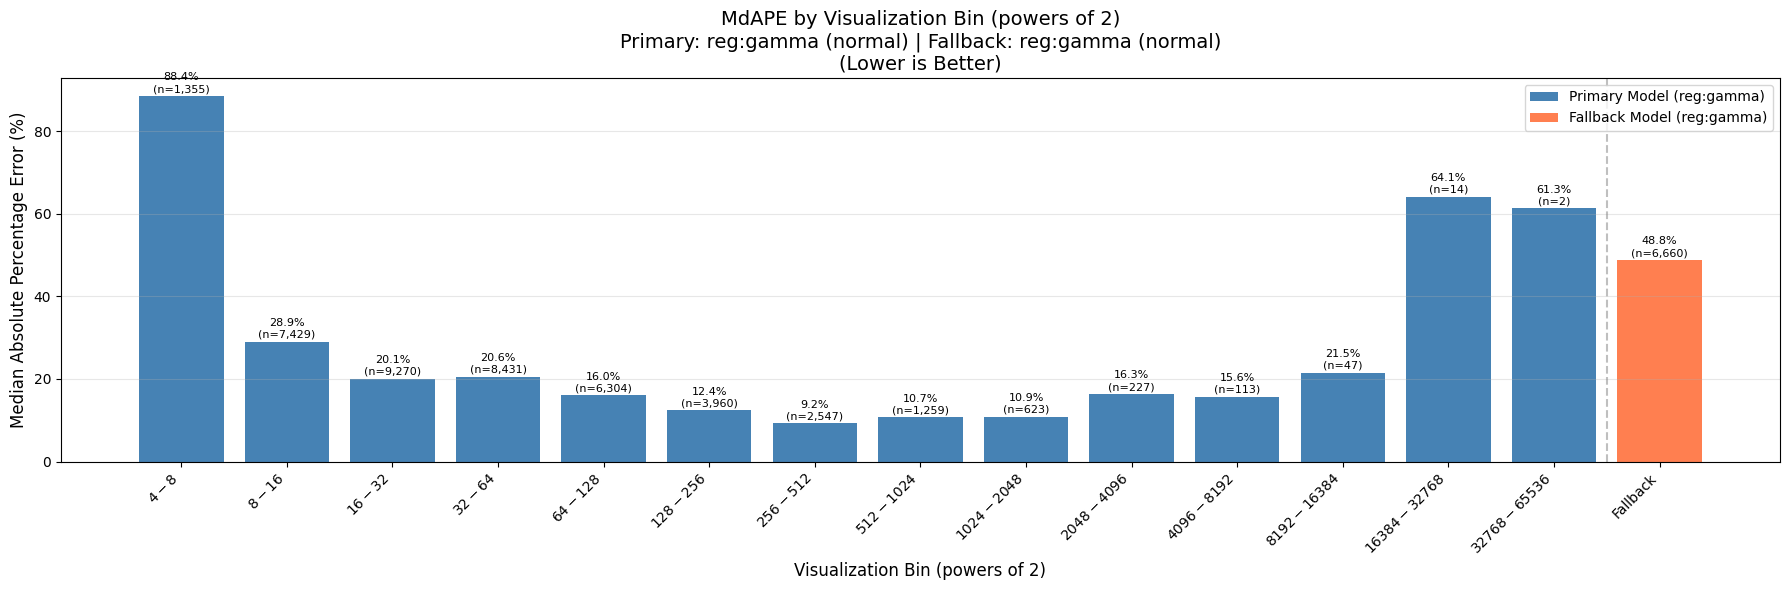


Saved: custom_bin_mdape_by_bin.png


In [7]:
# Cell 7: Visualization - MdAPE by Visualization Bin (including Fallback)
# Uses power-of-2 visualization bins, NOT the training bins

# Get viz bin labels with fallback
viz_labels_with_fallback = VIZ_BIN_LABELS + ["Fallback"]

# Create bar chart
fig, ax = plt.subplots(figsize=(max(12, len(viz_labels_with_fallback) * 1.2), 6))

x = np.arange(len(viz_labels_with_fallback))
mdape_values = []
counts = []

# Get values for visualization bins
for bin_idx in range(len(VIZ_BIN_LABELS)):
    if bin_idx in results_by_viz_bin:
        mdape = results_by_viz_bin[bin_idx]["mdape"]
        count = results_by_viz_bin[bin_idx]["count"]
        mdape_values.append(mdape if not np.isnan(mdape) else 0)
        counts.append(count)
    else:
        mdape_values.append(0)
        counts.append(0)

# Add fallback value
if "fallback" in results_by_viz_bin:
    fallback_mdape = results_by_viz_bin["fallback"]["mdape"]
    mdape_values.append(fallback_mdape if not np.isnan(fallback_mdape) else 0)
    counts.append(results_by_viz_bin["fallback"]["count"])
else:
    mdape_values.append(0)
    counts.append(0)

# Color visualization bins differently from fallback
colors = ['steelblue'] * len(VIZ_BIN_LABELS) + ['coral']

bars = ax.bar(x, mdape_values, color=colors)

# Add value labels on bars
for bar, val, count in zip(bars, mdape_values, counts):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{val:.1f}%\n(n={count:,})", ha='center', va='bottom', fontsize=8)

ax.set_xlabel("Visualization Bin (powers of 2)", fontsize=12)
ax.set_ylabel("Median Absolute Percentage Error (%)", fontsize=12)
ax.set_title(f"MdAPE by Visualization Bin (powers of 2)\nPrimary: {PRIMARY_OBJECTIVE} ({PRIMARY_DATASET}) | Fallback: {FALLBACK_OBJECTIVE} ({FALLBACK_DATASET})\n(Lower is Better)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(viz_labels_with_fallback, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add vertical line to separate bins from fallback
ax.axvline(x=len(VIZ_BIN_LABELS) - 0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label=f'Primary Model ({PRIMARY_OBJECTIVE})'),
    Patch(facecolor='coral', label=f'Fallback Model ({FALLBACK_OBJECTIVE})')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig("custom_bin_mdape_by_bin.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: custom_bin_mdape_by_bin.png")

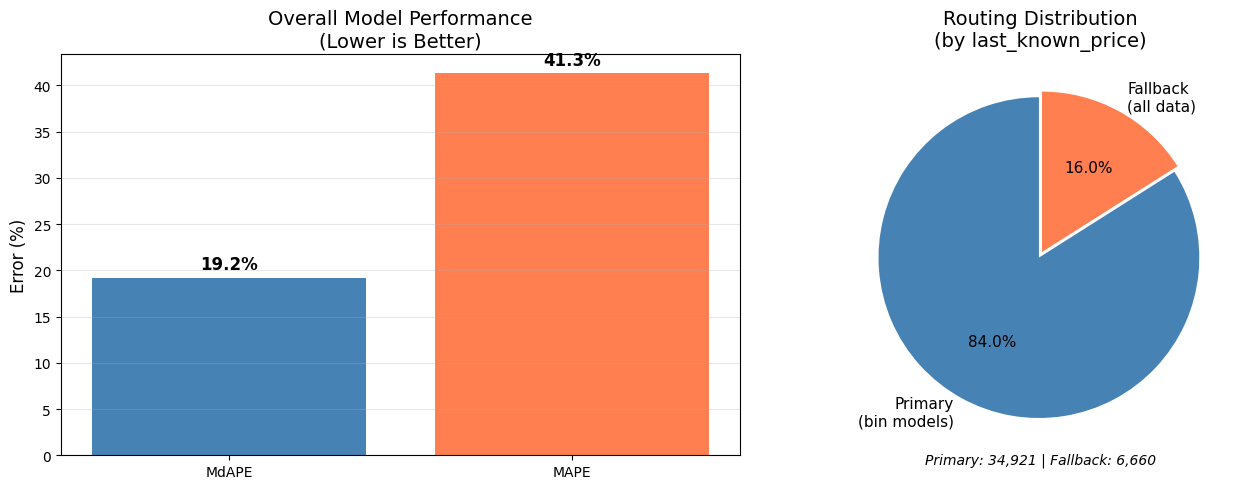


Saved: custom_bin_overall_comparison.png


In [8]:
# Cell 8: Overall Performance Summary

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: MdAPE vs MAPE comparison
ax1 = axes[0]
metrics = ['MdAPE', 'MAPE']
values = [overall_mdape, overall_mape]
colors = ['steelblue', 'coral']

bars = ax1.bar(metrics, values, color=colors)
for bar, val in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{val:.1f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel("Error (%)", fontsize=12)
ax1.set_title("Overall Model Performance\n(Lower is Better)", fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Right plot: Routing distribution
ax2 = axes[1]
total_samples = sum(stats['bin_counts'].values()) + stats['fallback_count']
primary_pct = sum(stats['bin_counts'].values()) / total_samples * 100
fallback_pct = stats['fallback_count'] / total_samples * 100

labels = ['Primary\n(bin models)', 'Fallback\n(all data)']
sizes = [primary_pct, fallback_pct]
colors = ['steelblue', 'coral']
explode = (0.02, 0.02)

wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=colors,
                                    autopct='%1.1f%%', startangle=90,
                                    textprops={'fontsize': 11})
ax2.set_title("Routing Distribution\n(by last_known_price)", fontsize=14)

# Add counts as subtitle
ax2.text(0, -1.3, f"Primary: {sum(stats['bin_counts'].values()):,} | Fallback: {stats['fallback_count']:,}",
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig("custom_bin_overall_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: custom_bin_overall_comparison.png")

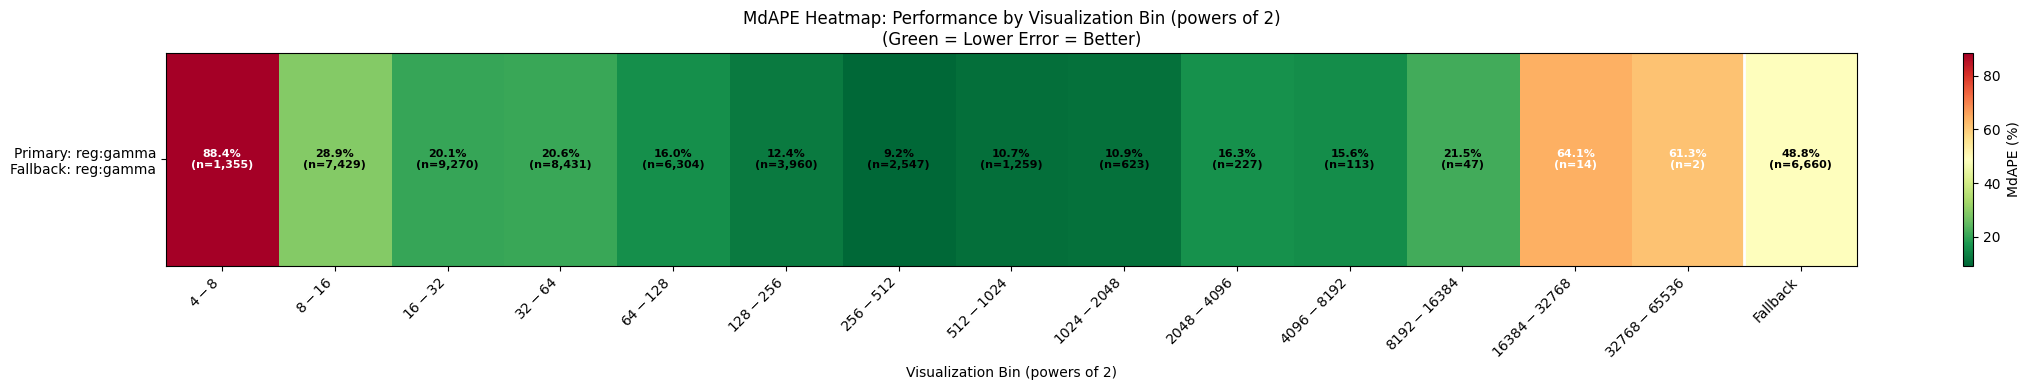


Saved: custom_bin_heatmap.png


In [9]:
# Cell 9: Heatmap Visualization (using visualization bins)

# Create heatmap showing MdAPE for each visualization bin + fallback
fig, ax = plt.subplots(figsize=(max(14, len(VIZ_BIN_LABELS) * 1.5 + 2), 4))

# Build data for heatmap (single row for this configuration)
heatmap_labels = VIZ_BIN_LABELS + ["Fallback"]
mdape_row = []
count_row = []

for bin_idx in range(len(VIZ_BIN_LABELS)):
    if bin_idx in results_by_viz_bin:
        mdape = results_by_viz_bin[bin_idx]["mdape"]
        count = results_by_viz_bin[bin_idx]["count"]
        mdape_row.append(mdape if not np.isnan(mdape) else np.nan)
        count_row.append(count)
    else:
        mdape_row.append(np.nan)
        count_row.append(0)

# Add fallback
if "fallback" in results_by_viz_bin:
    mdape_row.append(results_by_viz_bin["fallback"]["mdape"])
    count_row.append(results_by_viz_bin["fallback"]["count"])
else:
    mdape_row.append(np.nan)
    count_row.append(0)

matrix = np.array([mdape_row])

# Create masked array to handle NaN
matrix_masked = np.ma.masked_invalid(matrix)

# Clip for visualization
matrix_clipped = np.clip(matrix_masked, 0, 100)

im = ax.imshow(matrix_clipped, cmap='RdYlGn_r', aspect='auto')

# Add text annotations
for j in range(len(heatmap_labels)):
    val = matrix[0, j]
    if not np.isnan(val):
        text_color = 'white' if matrix_clipped[0, j] > 50 else 'black'
        count = count_row[j]
        ax.text(j, 0, f"{val:.1f}%\n(n={count:,})", ha='center', va='center',
                fontsize=8, color=text_color, fontweight='bold')

ax.set_xticks(range(len(heatmap_labels)))
ax.set_xticklabels(heatmap_labels, rotation=45, ha='right')
ax.set_yticks([0])
ax.set_yticklabels([f"Primary: {PRIMARY_OBJECTIVE}\nFallback: {FALLBACK_OBJECTIVE}"])
ax.set_xlabel("Visualization Bin (powers of 2)")
ax.set_title("MdAPE Heatmap: Performance by Visualization Bin (powers of 2)\n(Green = Lower Error = Better)")

# Add vertical line to separate bins from fallback
ax.axvline(x=len(VIZ_BIN_LABELS) - 0.5, color='white', linestyle='-', linewidth=2)

plt.colorbar(im, ax=ax, label="MdAPE (%)")

plt.tight_layout()
plt.savefig("custom_bin_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: custom_bin_heatmap.png")

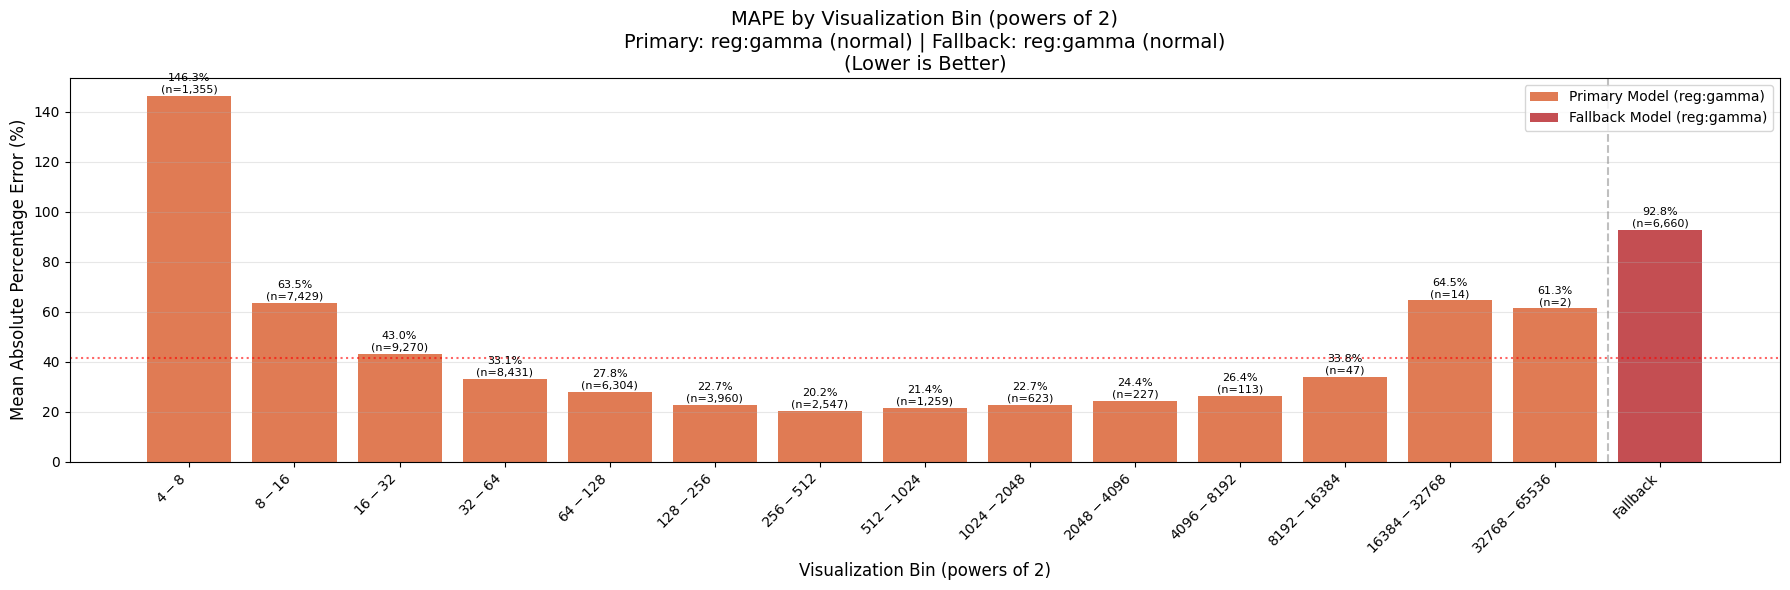


Saved: custom_bin_mape_by_bin.png


In [10]:
# Cell 10: Visualization - MAPE by Visualization Bin (including Fallback)
# Mirrors the MdAPE bar chart but uses Mean Absolute Percentage Error

viz_labels_with_fallback_mape = VIZ_BIN_LABELS + ["Fallback"]

fig, ax = plt.subplots(figsize=(max(12, len(viz_labels_with_fallback_mape) * 1.2), 6))

x = np.arange(len(viz_labels_with_fallback_mape))
mape_values = []
mape_counts = []

for bin_idx in range(len(VIZ_BIN_LABELS)):
    if bin_idx in results_by_viz_bin:
        mape = results_by_viz_bin[bin_idx]["mape"]
        count = results_by_viz_bin[bin_idx]["count"]
        mape_values.append(mape if not np.isnan(mape) else 0)
        mape_counts.append(count)
    else:
        mape_values.append(0)
        mape_counts.append(0)

# Add fallback value
if "fallback" in results_by_viz_bin:
    fb_mape = results_by_viz_bin["fallback"]["mape"]
    mape_values.append(fb_mape if not np.isnan(fb_mape) else 0)
    mape_counts.append(results_by_viz_bin["fallback"]["count"])
else:
    mape_values.append(0)
    mape_counts.append(0)

colors_mape = ['#e07b54'] * len(VIZ_BIN_LABELS) + ['#c44e52']

bars = ax.bar(x, mape_values, color=colors_mape)

# Add value labels on bars
for bar, val, count in zip(bars, mape_values, mape_counts):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{val:.1f}%\n(n={count:,})", ha='center', va='bottom', fontsize=8)

ax.set_xlabel("Visualization Bin (powers of 2)", fontsize=12)
ax.set_ylabel("Mean Absolute Percentage Error (%)", fontsize=12)
ax.set_title(
    f"MAPE by Visualization Bin (powers of 2)\n"
    f"Primary: {PRIMARY_OBJECTIVE} ({PRIMARY_DATASET}) | "
    f"Fallback: {FALLBACK_OBJECTIVE} ({FALLBACK_DATASET})\n"
    "(Lower is Better)",
    fontsize=14,
)
ax.set_xticks(x)
ax.set_xticklabels(viz_labels_with_fallback_mape, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Vertical line to separate bins from fallback
ax.axvline(x=len(VIZ_BIN_LABELS) - 0.5, color='gray', linestyle='--', alpha=0.5)

# Horizontal reference line for overall MAPE
ax.axhline(y=overall_mape, color='red', linestyle=':', alpha=0.6, label=f'Overall MAPE ({overall_mape:.1f}%)')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e07b54', label=f'Primary Model ({PRIMARY_OBJECTIVE})'),
    Patch(facecolor='#c44e52', label=f'Fallback Model ({FALLBACK_OBJECTIVE})'),
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig("custom_bin_mape_by_bin.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: custom_bin_mape_by_bin.png")

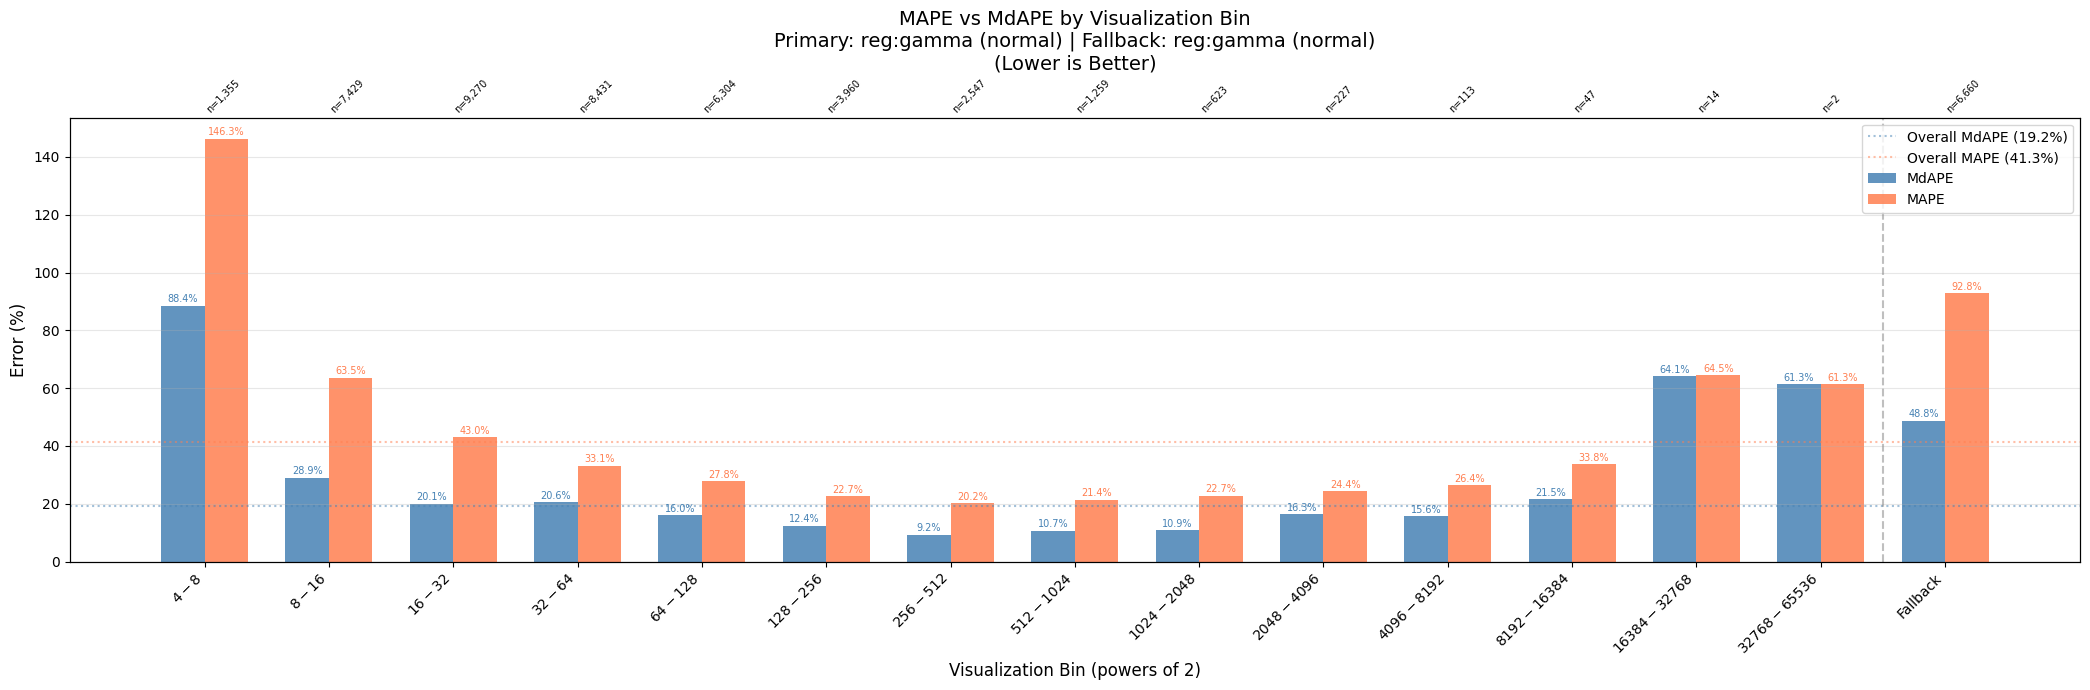


Saved: custom_bin_mape_vs_mdape_comparison.png

MAPE / MdAPE ratio by bin (>1 means right-skewed errors, i.e. some large outlier errors):
  $4-$8          : MAPE/MdAPE = 1.65
  $8-$16         : MAPE/MdAPE = 2.20 < moderate outliers
  $16-$32        : MAPE/MdAPE = 2.14 < moderate outliers
  $32-$64        : MAPE/MdAPE = 1.61
  $64-$128       : MAPE/MdAPE = 1.74
  $128-$256      : MAPE/MdAPE = 1.83
  $256-$512      : MAPE/MdAPE = 2.19 < moderate outliers
  $512-$1024     : MAPE/MdAPE = 2.00 < moderate outliers
  $1024-$2048    : MAPE/MdAPE = 2.09 < moderate outliers
  $2048-$4096    : MAPE/MdAPE = 1.50
  $4096-$8192    : MAPE/MdAPE = 1.69
  $8192-$16384   : MAPE/MdAPE = 1.57
  $16384-$32768  : MAPE/MdAPE = 1.01
  $32768-$65536  : MAPE/MdAPE = 1.00
  Fallback       : MAPE/MdAPE = 1.90


In [11]:
# Cell 11: Visualization - MAPE vs MdAPE Comparison by Visualization Bin
# Grouped bar chart showing both metrics side-by-side for each bin

comparison_labels = VIZ_BIN_LABELS + ["Fallback"]
n_groups = len(comparison_labels)

mdape_vals = []
mape_vals = []
sample_counts = []

for bin_idx in range(len(VIZ_BIN_LABELS)):
    if bin_idx in results_by_viz_bin:
        md = results_by_viz_bin[bin_idx]["mdape"]
        ma = results_by_viz_bin[bin_idx]["mape"]
        cnt = results_by_viz_bin[bin_idx]["count"]
        mdape_vals.append(md if not np.isnan(md) else 0)
        mape_vals.append(ma if not np.isnan(ma) else 0)
        sample_counts.append(cnt)
    else:
        mdape_vals.append(0)
        mape_vals.append(0)
        sample_counts.append(0)

# Fallback
if "fallback" in results_by_viz_bin:
    mdape_vals.append(results_by_viz_bin["fallback"]["mdape"])
    mape_vals.append(results_by_viz_bin["fallback"]["mape"])
    sample_counts.append(results_by_viz_bin["fallback"]["count"])
else:
    mdape_vals.append(0)
    mape_vals.append(0)
    sample_counts.append(0)

x = np.arange(n_groups)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(max(14, n_groups * 1.4), 7))

bars_mdape = ax.bar(x - bar_width/2, mdape_vals, bar_width, label='MdAPE', color='steelblue', alpha=0.85)
bars_mape = ax.bar(x + bar_width/2, mape_vals, bar_width, label='MAPE', color='coral', alpha=0.85)

# Value labels
for bar, val in zip(bars_mdape, mdape_vals):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{val:.1f}%", ha='center', va='bottom', fontsize=7, color='steelblue')

for bar, val in zip(bars_mape, mape_vals):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{val:.1f}%", ha='center', va='bottom', fontsize=7, color='coral')

# Reference lines for overall values
ax.axhline(y=overall_mdape, color='steelblue', linestyle=':', alpha=0.5,
           label=f'Overall MdAPE ({overall_mdape:.1f}%)')
ax.axhline(y=overall_mape, color='coral', linestyle=':', alpha=0.5,
           label=f'Overall MAPE ({overall_mape:.1f}%)')

# Vertical separator before fallback
ax.axvline(x=len(VIZ_BIN_LABELS) - 0.5, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel("Visualization Bin (powers of 2)", fontsize=12)
ax.set_ylabel("Error (%)", fontsize=12)
ax.set_title(
    "MAPE vs MdAPE by Visualization Bin\n"
    f"Primary: {PRIMARY_OBJECTIVE} ({PRIMARY_DATASET}) | "
    f"Fallback: {FALLBACK_OBJECTIVE} ({FALLBACK_DATASET})\n"
    "(Lower is Better)",
    fontsize=14,
)
ax.set_xticks(x)
ax.set_xticklabels(comparison_labels, rotation=45, ha='right')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add sample counts as secondary x-axis labels
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(x)
ax2.set_xticklabels([f'n={c:,}' for c in sample_counts], fontsize=7, rotation=45, ha='left')
ax2.tick_params(axis='x', length=0, pad=2)

plt.tight_layout()
plt.savefig("custom_bin_mape_vs_mdape_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: custom_bin_mape_vs_mdape_comparison.png")

# Print MAPE/MdAPE ratio (shows how skewed the error distribution is per bin)
print("\nMAPE / MdAPE ratio by bin (>1 means right-skewed errors, i.e. some large outlier errors):")
for i, label in enumerate(comparison_labels):
    if mdape_vals[i] > 0:
        ratio = mape_vals[i] / mdape_vals[i]
        flag = " << heavy outliers" if ratio > 3 else (" < moderate outliers" if ratio > 2 else "")
        print(f"  {label:<15}: MAPE/MdAPE = {ratio:.2f}{flag}")

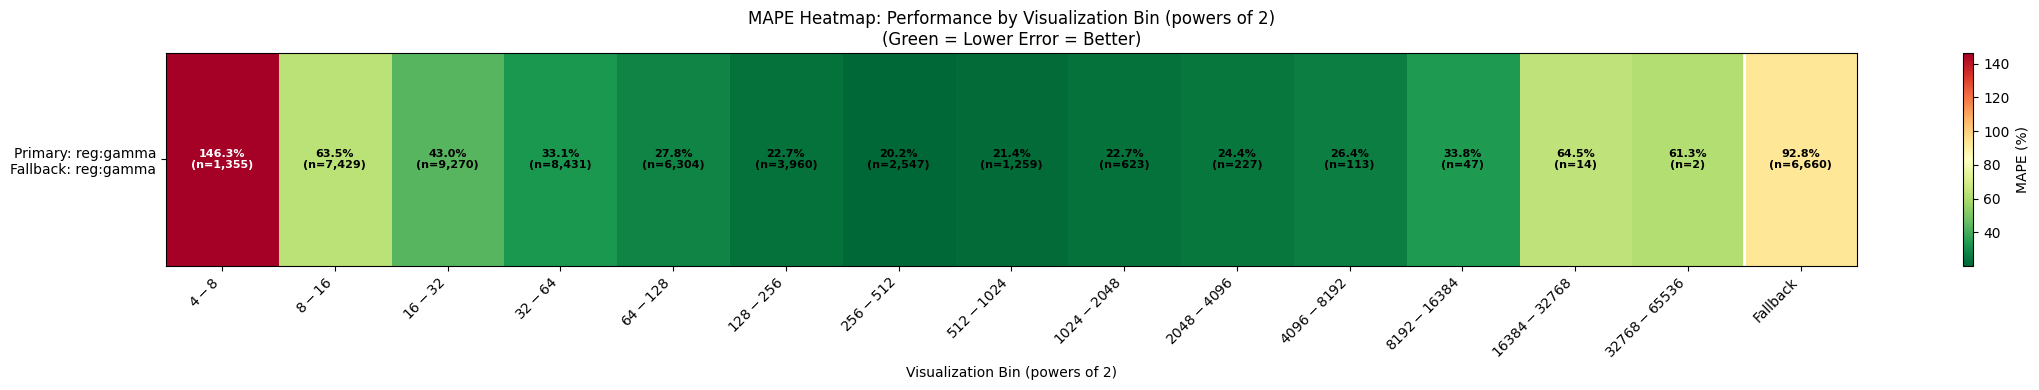


Saved: custom_bin_mape_heatmap.png


In [12]:
# Cell 12: Heatmap Visualization - MAPE (using visualization bins)
# Mirrors the MdAPE heatmap but uses Mean Absolute Percentage Error

fig, ax = plt.subplots(figsize=(max(14, len(VIZ_BIN_LABELS) * 1.5 + 2), 4))

heatmap_labels_mape = VIZ_BIN_LABELS + ["Fallback"]
mape_row = []
count_row_mape = []

for bin_idx in range(len(VIZ_BIN_LABELS)):
    if bin_idx in results_by_viz_bin:
        mape = results_by_viz_bin[bin_idx]["mape"]
        count = results_by_viz_bin[bin_idx]["count"]
        mape_row.append(mape if not np.isnan(mape) else np.nan)
        count_row_mape.append(count)
    else:
        mape_row.append(np.nan)
        count_row_mape.append(0)

# Add fallback
if "fallback" in results_by_viz_bin:
    mape_row.append(results_by_viz_bin["fallback"]["mape"])
    count_row_mape.append(results_by_viz_bin["fallback"]["count"])
else:
    mape_row.append(np.nan)
    count_row_mape.append(0)

matrix_mape = np.array([mape_row])
matrix_mape_masked = np.ma.masked_invalid(matrix_mape)

# Clip for visualization (MAPE can be very large due to outliers)
mape_clip_max = 200
matrix_mape_clipped = np.clip(matrix_mape_masked, 0, mape_clip_max)

im = ax.imshow(matrix_mape_clipped, cmap='RdYlGn_r', aspect='auto')

# Add text annotations
for j in range(len(heatmap_labels_mape)):
    val = matrix_mape[0, j]
    if not np.isnan(val):
        text_color = 'white' if matrix_mape_clipped[0, j] > (mape_clip_max / 2) else 'black'
        count = count_row_mape[j]
        ax.text(j, 0, f"{val:.1f}%\n(n={count:,})", ha='center', va='center',
                fontsize=8, color=text_color, fontweight='bold')

ax.set_xticks(range(len(heatmap_labels_mape)))
ax.set_xticklabels(heatmap_labels_mape, rotation=45, ha='right')
ax.set_yticks([0])
ax.set_yticklabels([f"Primary: {PRIMARY_OBJECTIVE}\nFallback: {FALLBACK_OBJECTIVE}"])
ax.set_xlabel("Visualization Bin (powers of 2)")
ax.set_title("MAPE Heatmap: Performance by Visualization Bin (powers of 2)\n(Green = Lower Error = Better)")

# Vertical line to separate bins from fallback
ax.axvline(x=len(VIZ_BIN_LABELS) - 0.5, color='white', linestyle='-', linewidth=2)

plt.colorbar(im, ax=ax, label="MAPE (%)")

plt.tight_layout()
plt.savefig("custom_bin_mape_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: custom_bin_mape_heatmap.png")

In [13]:
# Cell 13: Summary & Recommendations

print("=" * 80)
print("SUMMARY: CUSTOM BIN STRATEGY ANALYSIS")
print("=" * 80)

print(f"\nModel Configuration (from constants.py):")
print(f"  Primary Model (bin-specific):")
print(f"    Objective: {PRIMARY_OBJECTIVE}")
print(f"    Dataset: {PRIMARY_DATASET}")
print(f"  Fallback Model (all data):")
print(f"    Objective: {FALLBACK_OBJECTIVE}")
print(f"    Dataset: {FALLBACK_DATASET}")

print(f"\nTraining Bin Configuration (from constants.py):")
print(f"  Edges (dollars): {CUSTOM_BIN_EDGES_DOLLARS}")
print(f"  Labels: {BIN_LABELS}")
print(f"  Number of bins: {len(BIN_LABELS)}")

print(f"\nVisualization Bin Configuration (powers of 2):")
print(f"  Edges (dollars): {VIZ_BIN_EDGES_DOLLARS}")
print(f"  Number of bins: {len(VIZ_BIN_LABELS)}")

print("\n" + "-" * 60)
print("1. OVERALL PERFORMANCE")
print("-" * 60)
print(f"  Overall MdAPE: {overall_mdape:.2f}%")
print(f"  Overall MAPE:  {overall_mape:.2f}%")
print(f"  MAPE/MdAPE ratio: {overall_mape / overall_mdape:.2f}x (>1 indicates right-skewed errors)")

print("\n" + "-" * 60)
print("2. PERFORMANCE BY VISUALIZATION BIN (powers of 2)")
print("-" * 60)
print(f"  {'Bin':<6} {'Price Range':<20} {'MdAPE':>10} {'MAPE':>10} {'MAPE/MdAPE':>12} {'Samples':>10}")
print("  " + "-" * 70)

for bin_idx in range(len(VIZ_BIN_LABELS)):
    if bin_idx in results_by_viz_bin:
        data = results_by_viz_bin[bin_idx]
        mdape = data['mdape']
        mape = data['mape']
        count = data['count']
        label = data['label']
        if not np.isnan(mdape) and not np.isnan(mape):
            ratio = mape / mdape if mdape > 0 else float('inf')
            print(f"  Bin {bin_idx:<3} {label:<20} {mdape:>9.2f}% {mape:>9.2f}% {ratio:>11.2f}x {count:>10,}")

print("\n" + "-" * 60)
print("3. FALLBACK MODEL PERFORMANCE")
print("-" * 60)
if "fallback" in results_by_viz_bin:
    data = results_by_viz_bin["fallback"]
    print(f"  MdAPE: {data['mdape']:.2f}%")
    print(f"  MAPE:  {data['mape']:.2f}%")
    if data['mdape'] > 0:
        print(f"  MAPE/MdAPE ratio: {data['mape'] / data['mdape']:.2f}x")
    print(f"  Samples: {data['count']:,} (cards without price history)")
else:
    print(f"  No samples routed to fallback")

print("\n" + "-" * 60)
print("4. ROUTING DISTRIBUTION")
print("-" * 60)

total = sum(stats['bin_counts'].values()) + stats['fallback_count']

print("\nSample distribution by visualization bin (validation set):")
for bin_idx in range(len(VIZ_BIN_LABELS)):
    if bin_idx in results_by_viz_bin:
        count = results_by_viz_bin[bin_idx]['count']
    else:
        count = 0
    pct = count / total * 100 if total > 0 else 0
    bar = "#" * int(pct / 2)
    print(f"  Bin {bin_idx} ({VIZ_BIN_LABELS[bin_idx]:<15}): {count:>8,} ({pct:>5.1f}%) {bar}")

# Show fallback distribution
if stats['fallback_count'] > 0:
    pct = stats['fallback_count'] / total * 100 if total > 0 else 0
    bar = "#" * int(pct / 2)
    print(f"  Fallback (no history      ): {stats['fallback_count']:>8,} ({pct:>5.1f}%) {bar}")

# Check for imbalanced visualization bins
bin_counts = [results_by_viz_bin[i]['count'] for i in range(len(VIZ_BIN_LABELS)) if i in results_by_viz_bin]
if bin_counts:
    max_count = max(bin_counts)
    min_count = min(bin_counts) if min(bin_counts) > 0 else 1
    ratio = max_count / min_count
    
    if ratio > 10:
        print(f"\n>>> WARNING: Price bins are highly imbalanced (ratio {ratio:.1f}:1).")
        print("    Consider adjusting bin edges for more balanced distribution.")
    elif ratio > 5:
        print(f"\n>>> NOTE: Price bins are moderately imbalanced (ratio {ratio:.1f}:1).")
    else:
        print(f"\n>>> Price bins are reasonably balanced (ratio {ratio:.1f}:1).")

# Show fallback percentage
if total > 0:
    fallback_pct = stats['fallback_count'] / total * 100
    print(f"\nFallback model handles {fallback_pct:.1f}% of validation samples ({stats['fallback_count']:,} cards without price history)")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nThis analysis matches the production behavior of step_7.py and step_8.py:")
print(f"  - Primary model ({PRIMARY_OBJECTIVE}) handles bin-specific predictions")
print(f"  - Fallback model ({FALLBACK_OBJECTIVE}) handles cards without price history")
print(f"  - Routing is based on last_known_price (NaN = fallback)")

SUMMARY: CUSTOM BIN STRATEGY ANALYSIS

Model Configuration (from constants.py):
  Primary Model (bin-specific):
    Objective: reg:gamma
    Dataset: normal
  Fallback Model (all data):
    Objective: reg:gamma
    Dataset: normal

Training Bin Configuration (from constants.py):
  Edges (dollars): [0.01, 8, 32, 64, 128, 1024, inf]
  Labels: ['$0.01-$8', '$8-$32', '$32-$64', '$64-$128', '$128-$1024', '$1024+']
  Number of bins: 6

Visualization Bin Configuration (powers of 2):
  Edges (dollars): [4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0, 8192.0, 16384.0, 32768.0, 65536.0]
  Number of bins: 14

------------------------------------------------------------
1. OVERALL PERFORMANCE
------------------------------------------------------------
  Overall MdAPE: 19.18%
  Overall MAPE:  41.30%
  MAPE/MdAPE ratio: 2.15x (>1 indicates right-skewed errors)

------------------------------------------------------------
2. PERFORMANCE BY VISUALIZATION BIN (powers of 2)
---